In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
import os
from brainspace.gradient import GradientMaps


In [21]:
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
hippunfold_dir = '/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold'
gradient_dir = '/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/Gradients/'
tmp_dir = 'tmp_PNI-FC'

subs = ['PNC001', 'PNC003', 'PNC004', 'PNC005', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC012', 'PNC013']# 'sub-PNC011', 
ses = '01'
hemis = ['L','R']
labels = ['hipp','dentate'] 

/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNC001/ses-01/surf/sub-PNC001_ses-01_hemi-L_space-T1w_den-0p5mm_label-dentate_*subfields*.label.gii failed
/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0/hippunfold/sub-PNC001/ses-01/surf/sub-PNC001_ses-01_hemi-R_space-T1w_den-0p5mm_label-dentate_*subfields*.label.gii failed


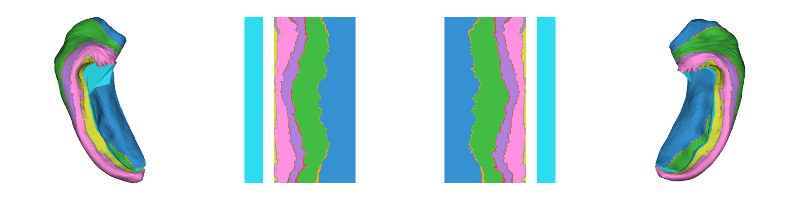

In [23]:
plotting.surfplot_sub_foldunfold(hippunfold_dir,subs[0],ses,['subfields'], size=[400,200], embed_nb=True)

In [3]:
# warp surfaces to func space then sample
sigma = 2 #Gaussian smoothing kernal sigma (mm)
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    # convert affines
    cmd1a = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-rest_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
    !{cmd1a}
    cmd1b = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_0GenericAffine.mat '\
        f'-inv '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
    !{cmd1b}

    for h in range(len(hemi)):
        for l in range(len(label)):
            
            #apply affines
            cmd2a = f'wb_command -surface-apply-affine '\
                f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

            !{cmd2a}
            cmd2b = f'wb_command -surface-apply-affine '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
            !{cmd2b}
            
            # apply warp (Note this is actually the INVERSE warp)
            cmd3 = f'wb_command -surface-apply-warpfield '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
            !{cmd3}


            # sample
            cmd4 = f'wb_command -volume-to-surface-mapping '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'-enclosing'
            !{cmd4}
            
            # smooth
            cmd5 = f'wb_command -metric-smoothing '\
                f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'{sigma} '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
            !{cmd5}
            
            # downsample
            func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
            out_array = np.ones((len(func.darrays),shp[l]))
            for k in range(len(func.darrays)):
                data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label[l],'nearest')
                out_array[k,:] = data
            data_array = nib.gifti.GiftiDataArray(data=data)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_rsfMRI_smooth-{sigma}mm.func.gii')

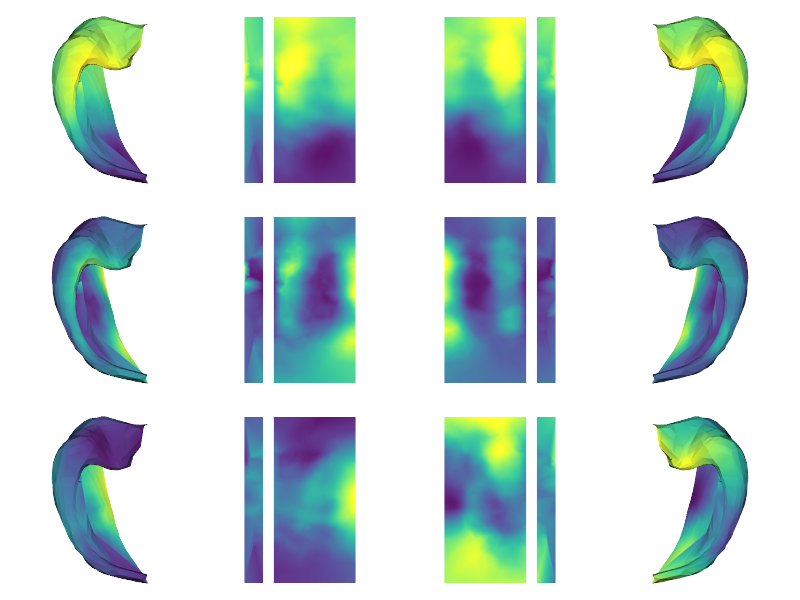

In [17]:
# load and plot reference gradients 
HCPL_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-L.npy')
HCPR_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-R.npy')
plotting.surfplot_canonical_foldunfold(np.stack((HCPL_ref[:,:3],HCPR_ref[:,:3]),axis=1), den='2mm', size=[400,200], embed_nb=True)

In [24]:
#run gradients for all subjects
ngrads = 10
all_grads = np.zeros((483,2,ngrads))
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')


clipaftertime = 200 # in TRs. This is an approximation
for sub in subs:
    neo_cdata = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_atlas-schaefer-400_desc-timeseries_clean.shape.gii').darrays[0].data
    neo_cdataL = neo_cdata[:200,:]
    neo_cdataR = neo_cdata[200:400,:]
    for h in range(len(hemi)):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-hipp_rsfMRI.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-dentate_rsfMRI.func.gii').darrays[0].data
        hipp_neo_data = np.concatenate((cdata_hipp,cdata_dg), axis=0)
        if hemi[h] == 'L':
            FC = np.corrcoef(hipp_neo_data,neo_cdataL)
            gradients = gm.fit(FC[0:483,483:683], reference=HCPL_ref)
        else:            
            FC = np.corrcoef(hipp_neo_data,neo_cdataR)
            gradients = gm.fit(FC[0:483,483:683], reference=HCPR_ref)
            
        all_grads[:,h,:] = gradients.aligned_
        np.savetxt(os.path.join(gradient_dir, f'sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-{hemi[h]}_gradients.txt'), all_grads[:,h,:],delimiter=',')        
        
plotting.surfplot_canonical_foldunfold(all_grads[:,:,:3], den='2mm', size=[400,200], embed_nb=True)

ImageFileError: Empty file: '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC001/ses-01/func/desc-me_task-rest_bold/surf/sub-PNC001_ses-01_surf-fsLR-32k_atlas-schaefer-400_desc-timeseries_clean.shape.gii'

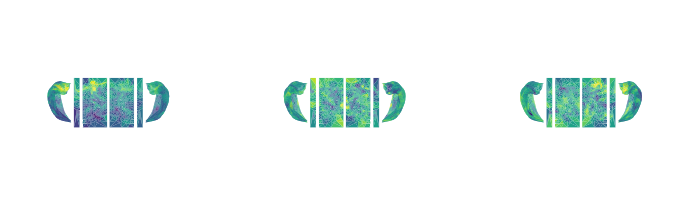

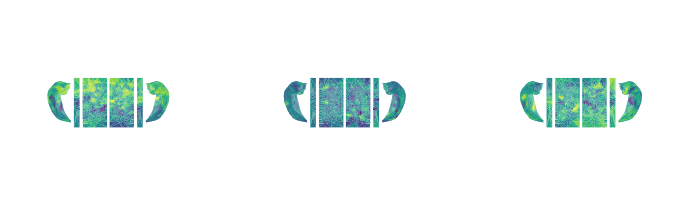

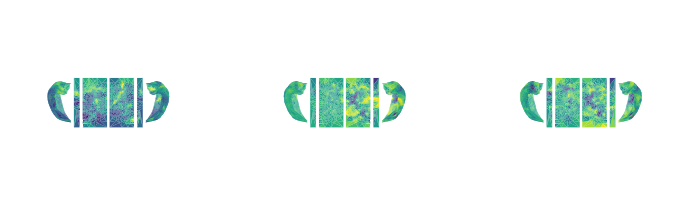

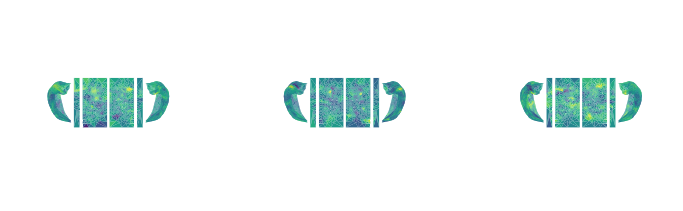

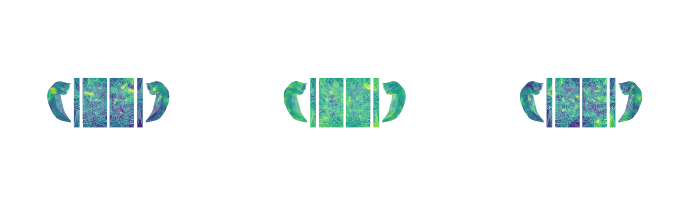

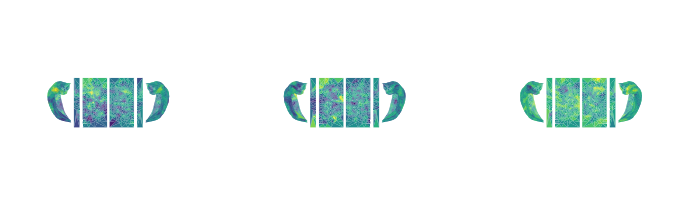

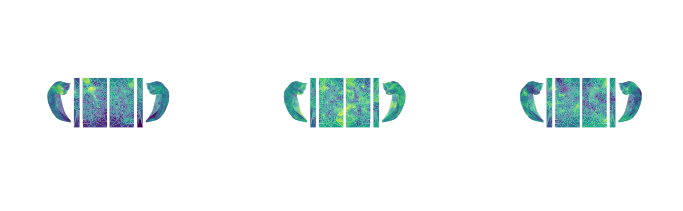

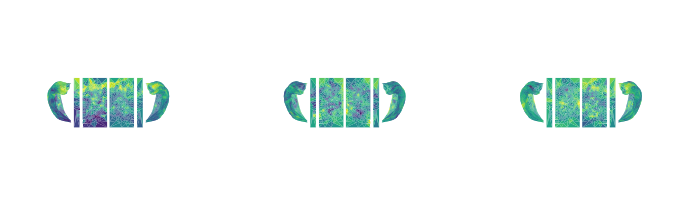

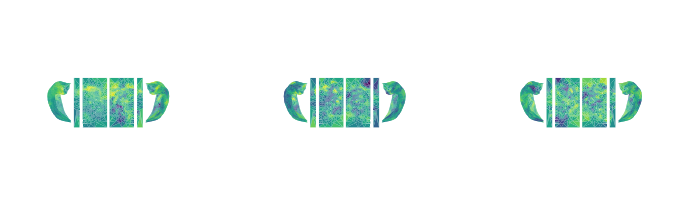

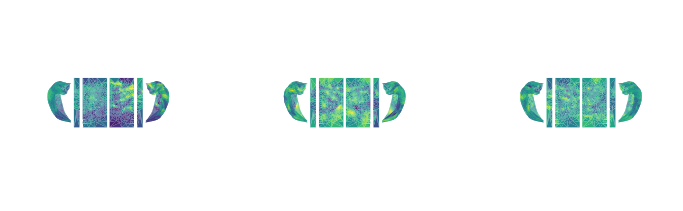

In [10]:
#plot subject specific gradients 
for sub in subs:
    gradientsL = np.loadtxt(f'{gradient_dir}/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-L_gradients.txt',delimiter=',')
    gradientsR = np.loadtxt(f'{gradient_dir}/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-R_gradients.txt',delimiter=',')
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12), subplot_kw={'projection': "3d"})
    for f in range(3):
        plotting.surfplot_canonical_foldunfold(ax[f], np.concatenate((gradientsL[:,f],gradientsR[:,f])), den='2mm')